# Project 4: Classification

### CMSC320

*Last Update*: 2020-04-28

### Data

We will use Mortgage Affordability data from Zillow to experiment with classification algorithms. The data was downloaded from Zillow Research page: https://www.zillow.com/research/data/

It is made available here: http://www.hcbravo.org/IntroDataSci/misc/Affordability_Wide_2017Q4_Public.csv

Download the csv file to your project directory.

### Preparing data

First, we will tidy the data. Please include this piece of code in your submission.

In [176]:
import pandas as pd
import numpy as np
from plotnine import *

theme_set(theme_bw())

In [177]:
# Read and prepare data

df = (pd.read_csv('data/Affordability_Wide_2017Q4_Public.csv')
        .query('Index == "Mortgage Affordability" and SizeRank != 0')
        .drop(columns=['Index', 'HistoricAverage_1985thru1999','SizeRank'])
        .dropna()
        .melt(id_vars=['RegionID','RegionName'],
              var_name='time', value_name='affordability'))
df['time'] = pd.to_datetime(df.time, format="%Y-%m")
df.head()


,RegionID,RegionName,time,affordability
0,394913,"New York, NY",1979-03-01,0.261700
1,753899,"Los Angeles-Long Beach-Anaheim, CA",1979-03-01,0.357694
2,394463,"Chicago, IL",1979-03-01,0.261928
3,394514,"Dallas-Fort Worth, TX",1979-03-01,0.301131
4,394974,"Philadelphia, PA",1979-03-01,0.204333


This is what the data looks like:

/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


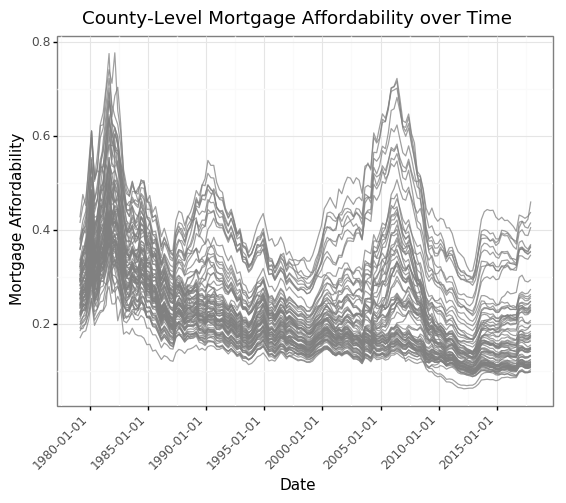

<ggplot: (302488959)>

In [178]:
# plot data

(ggplot(df, aes(x='time', y='affordability', group='factor(RegionID)')) +
  geom_line(color="GRAY", alpha=3/4, size=1/2) +
  theme(axis_text_x=element_text(angle=45,hjust=1)) +
  labs(title="County-Level Mortgage Affordability over Time",
          x="Date", y="Mortgage Affordability"))

## The prediction task

The prediction task we are going to answer is:

> Can we predict if mortgage affordability will increase or decrease a year from now"

Specifically, we will do this for quarter 4 (Q4) of 2017. To create the outcome we will predict we will compare affordability for Q4 of 2017 to Q4 of 2016 and label it as `up` or `down` depending on the sign of the this difference. Let's create the outcome we want to predict (again, copy this bit of code to your submission):



In [179]:
outcome_dates = ['2016-12-01', '2017-12-01']
outcome_df = (df.query('time in @outcome_dates')
   .pivot(index='RegionID', columns='time', values='affordability'))

outcome_df['diff'] = outcome_df['2017-12-01'] - outcome_df['2016-12-01']
outcome_df['Direction'] = 'Down'
outcome_df['Direction'] = outcome_df['Direction'].where(outcome_df['diff'] < 0, 'Up') # this replaces where conditions is False
outcome_df = outcome_df.reset_index()[['RegionID','Direction']]
outcome_df.head()

time,RegionID,Direction
0,394304,Down
1,394312,Down
2,394318,Down
3,394347,Up
4,394355,Up


Now, you have a dataframe with outcomes (labels) for each county in the dataset.

The goal is then given predictors $X_i$ for county $i$, build a classifier for outcome $G_i \in \{\mathtt{up},\mathtt{down}\}$.

To train your classifiers you should use data up to 2016. 

In [181]:
predictor_df = df.query('time < 20170101')

## Your project

Your goal for this project is to do an experiment to address a (one, single) technical question about our ability to make this prediction. Here is a list of possible questions you may address below. Each of them asks to compare two specific choices in the classification workflow (e.g., two classification algorithms, two feature representations, etc.). You will implement each of the two choices and use 10-fold cross validation (across RegionID's) to compare their relative performance. You will also create an AUROC curve to compare them.

### Possible Questions

#### Feature representation and preprocessing

- Does standardizing affordability for each region affect  prediction performance? Compare standardized to non-standardized affordability.
- Is using quarter to quarter change (continuous or discrete) improve prediction performance? Compare quarter to quarter change in affordability as predictors to affordability as predictor?
- Should we use the full time series for each region, or should we use only the last few years? Compare full time series to a subset of the time series?
- Should we expand the training set to multiple time series per region? For example, create a similar outcome for each time point in the dataset (change relative to affordability one year ago) and use data from the last couple of years as predictors. Train on the extended dataset and test on the 2017 data above?
- Should we do dimensionality reduction (PCA) and use the embedded data to do prediction?
- Create your own question!

#### Classification Algorithm

- Is a decision tree better than logistic regression?
- Is a random forest better than a decision tree?
- Is K-nearest neighbors bettern than a random forest?
- Create your own question!

Note that you still have to make some choices regardless of the question you choose. For example, to do the feature preprocessing and representation experiments you have to choose a classifier (random forest for example), and decide what to do about hyper-parameters if appropriate.

### Submission

Prepare a Jupyter notebook that which includes:

1) Code to prepare data (copied from chunks above), plus any additional data prep for your experiment    
2) Discussion of the question you have chosen to address including discussion of other choices you have made (e.g., feature representation, classification algorithm) to carry out your experiment.  
3) Code to carry out your cross-validation experiment.  
4) Table (result of hypothesis testing difference between algorithms) and plot comparing AUROCs  
5) ROC curves for both experimental settings.  
6) Interpretation and discussion of your experiment results.  

Save to pdf and submit on ELMS.

## An example experiment

Question: Does the number of trees used in a random forest classifier affect
performance (AUROC measured with 5-fold CV)?

Other decisions: We are transforming input data to use quarterly differences after data standardization for years 2014-2016. 

### Data preparation

First, filter to the years of interest and standardize affordability for each region.

In [188]:
# subset data and compute mean and standard deviation per region
tmp_df = predictor_df.query('time > 20131201 & time < 20170101')
stat_df = tmp_df.groupby('RegionID').agg({'affordability': ['mean', 'std']})
stat_df.columns = stat_df.columns.get_level_values(1)
stat_df.reset_index(col_level=1).set_index('RegionID')

# standardize affordability for each region
std_df = tmp_df.set_index('RegionID').join(stat_df)
std_df['std_affordability'] = (std_df['affordability'] - std_df['mean'])/std_df['std']
std_df.head()

,RegionName,time,affordability,mean,std,std_affordability
RegionID,,,,,,
394304,"Akron, OH",2014-03-01,0.110923,0.108193,0.003617,0.754555
394304,"Akron, OH",2014-06-01,0.109178,0.108193,0.003617,0.272298
394304,"Akron, OH",2014-09-01,0.108367,0.108193,0.003617,0.047965
394304,"Akron, OH",2014-12-01,0.104267,0.108193,0.003617,-1.085563
394304,"Akron, OH",2015-03-01,0.103859,0.108193,0.003617,-1.198250


To train our model we need a table with one row per region, and attributes corresponding to differences in quarterly affordability. We will do this in stages, first we turn the tidy dataset into a wide dataset using `pd.pivot` then create a dataframe containing the differences we use as features.

In [189]:
# switch to a 'wide' data frame
std_df['RegionID'] = std_df.index
std_df = (std_df[['RegionID','time','std_affordability']]
  .pivot(index='RegionID', columns='time', values='std_affordability'))

# construct matrix of quarterly differences
mat1 = std_df.iloc[:,1:].to_numpy()
mat2 = std_df.iloc[:,:-1].to_numpy()
X = mat1 - mat2

# get the outcome from the dataframe we created
outcome_df['y'] = 0
outcome_df['y'] = outcome_df['y'].where(outcome_df['Direction'] == "Down", 1)
y = outcome_df['y'].to_numpy()

### Run the experiment 

We will use but 5-fold cross-validation to compare a random forest with 500 trees, with a random forest with 10 trees. Since this is a smallish dataset, I am using 5-fold cross validation to make the validation sets have more examples and therefore more reliable performance estimates.


In [190]:
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pylab as plt
import numpy as np

In [191]:
small_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
big_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

parameters = {'max_features': [2,6,11]} # we do this to match what the R version did
small_cv = sklearn.model_selection.GridSearchCV(small_rf, parameters, cv=5)
big_cv = sklearn.model_selection.GridSearchCV(big_rf, parameters, cv=5)

# following sklearn tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=5)


def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

In [192]:
# get roc curve data for small model
small_curve_df, small_auc_df = get_roc_data(small_cv, cv_obj)
small_curve_df['model'] = 'small'
small_auc_df['model'] = 'small'

In [193]:
# get roc curve data for big model
big_curve_df, big_auc_df = get_roc_data(big_cv, cv_obj)
big_curve_df['model'] = 'big'
big_auc_df['model'] = 'big'

In [194]:
# combine the roc curve data
curve_df = pd.concat([small_curve_df, big_curve_df])
auc_df = pd.concat([small_auc_df, big_auc_df])

auc_df

,fold,auc,model
0,0,0.416667,small
1,1,0.466667,small
2,2,0.658333,small
3,3,0.366667,small
4,4,0.781818,small
0,0,0.433333,big
1,1,0.650000,big
2,2,0.658333,big
3,3,0.516667,big
4,4,0.572727,big


/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


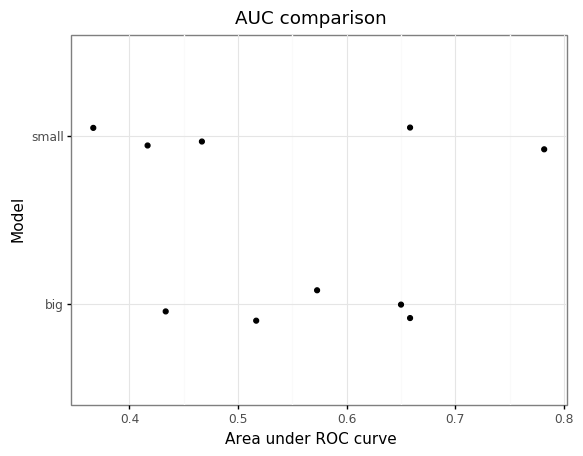

<ggplot: (305798327)>

In [197]:
# plot the distribution of auc estimates
(ggplot(auc_df, aes(x='model', y='auc')) + 
     geom_jitter(position=position_jitter(0.1)) +
     coord_flip() +
     labs(title = "AUC comparison",
          x="Model",
          y="Area under ROC curve"))

We test for differences using linear regression.

In [198]:
# use a two-sided test (based on linear regression) to see if there is a 
# statistically significant difference in auc estimates
import statsmodels.formula.api as smf
lm_fit = smf.ols('auc~model', data=auc_df).fit()

In [199]:
lm_fit.summary()

/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                    0.1001
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.760
Time:                        09:18:28   Log-Likelihood:                 6.5256
No. Observations:                  10   AIC:                            -9.051
Df Residuals:                       8   BIC:                            -8.446
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5662      0.063      8.988      0.000       0.421       0.711
model[T.small]    -0.0282      0.089     -0.316      0.760      -0.234       0.177
==============================================================================
Omnibus:                        0.629   Durbin-Watson:                   3.205
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.603
Skew:                           0.397   Prob(JB):                        0.740
Kurtosis:                       2.097   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a small decrease (2.8%) in average AUROC for the small model but it is not a statistically significant difference.

Finally, here are ROC curves of both models.

/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/hcorrada/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


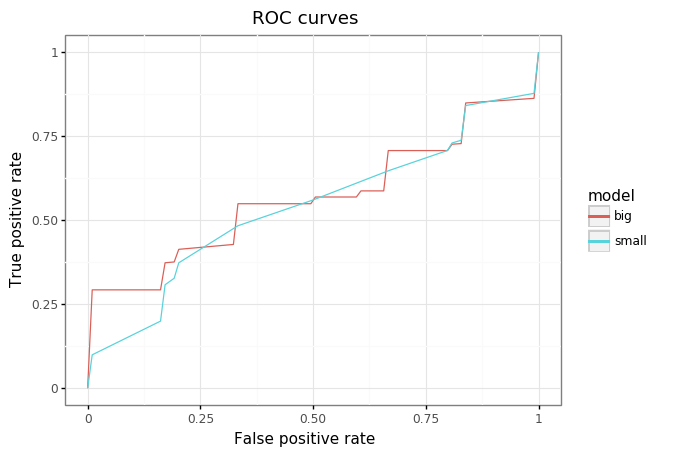

<ggplot: (306595911)>

In [204]:
mean_curve_df = curve_df.groupby(['model','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate"))

There is a small difference in the low false positive rate between the models, but essentially these models perform very similarly. Neither model is very good at this task.